### Quickstart Tutorial

Hi! Welcome to $\texttt{stella}$, a package to identify stellar flares using $\textit{TESS}$ two-minute data. Here, we'll run through an example of how to create a convolutional neural network (CNN) model and how to use it to predict where flares are in your own light curves. Let's get started!

In [1]:
import os, sys
sys.path.insert(1, '/Users/arcticfox/Documents/GitHub/stella/')
import stella
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20

#### 1.1 Download the Models

For this network, we'll be using the models created and used in Feinstein et al. (in prep). The models can be [downloaded here](https://github.com/afeinstein20/stella/blob/master/final_models.zip). Once the file is unzipped, you can load in the models within the directory.

In [12]:
MODEL_DIR = '/Users/arcticfox/Documents/GitHub/stella/final_models/'
MODELS = [os.path.join(MODEL_DIR,i) for i in 
          os.listdir(MODEL_DIR) if i.endswith('.h5')]
print(MODELS)

['/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0038_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0028_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0050_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0029_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0078_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0080_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0077_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0004_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0005_i0350_b0.73.h5', '/Users/arcticfox/Documents/GitHub/stella/final_models/ensemble_s0018_i0350_b0.73.h5']


#### 1.2 Using the Models

Step 1. Specifiy a directory where you'd like your models to be saved to. 

In [4]:
OUT_DIR = '/Users/arcticfox/Desktop/results/'

Step 2. Initialize the class! Call $\texttt{stella.ConvNN()}$ and pass in your directory. A message will appear that says you can only call $\texttt{stella.ConvNN.predict()}$. That's okay because we're doing to pass in the model later down the line.

In [5]:
cnn = stella.ConvNN(output_dir=OUT_DIR)

Can only use stella.ConvNN.predict().


The easiest thing you can do is pass in your light curves here! Let's grab an example star using $\texttt{lightkurve}$:

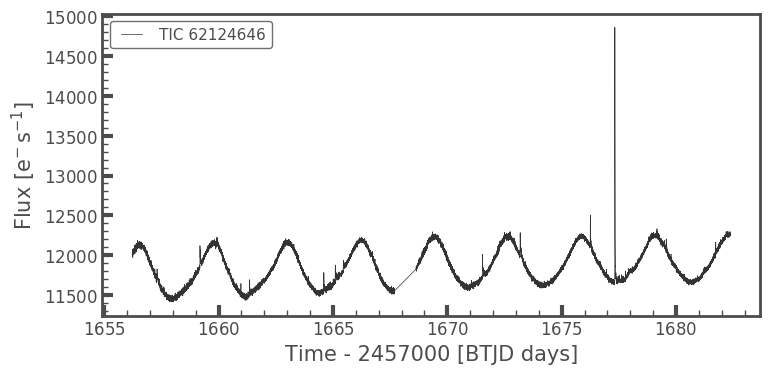

In [7]:
#### create a lightkurve for a two minute target here for the example
from lightkurve.search import search_lightcurvefile

lk = search_lightcurvefile(target='tic62124646', mission='TESS')
lk = lk.download().PDCSAP_FLUX
lk.plot()

Now we can use the model we saved to predict flares on new light curves! This is where it becomes important to keep track of your models and your output directory. To be extra sure you know what model you're using, in order to predict on new light curves you $\textit{must}$ input the model filename.

In [8]:
cnn.predict(modelname=MODELS[0],
            times=lk.time, 
            fluxes=lk.flux, 
            errs=lk.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Et voila... Predictions!

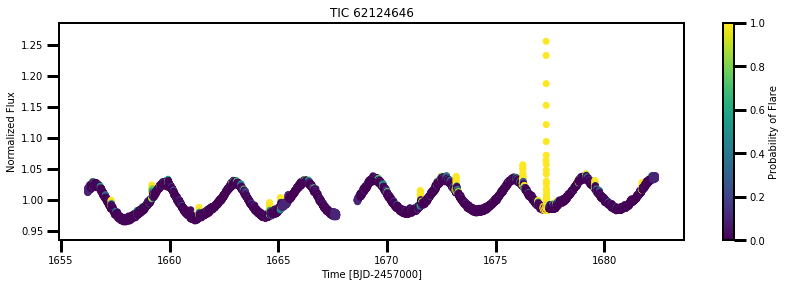

In [9]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lk.targetid));

Now you can loop through all 10 models provided and average over the predictions from each model. This is called $\textit{ensembling}$ and can provide more accurate predictions than using a single model.

In [10]:
preds = np.zeros((len(MODELS),len(cnn.predictions[0])))

for i, model in enumerate(MODELS):
    cnn.predict(modelname=model,
                times=lk.time,
                fluxes=lk.flux,
                errs=lk.flux_err)
    preds[i] = cnn.predictions[0]
    
avg_pred = np.nanmedian(preds, axis=0)

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


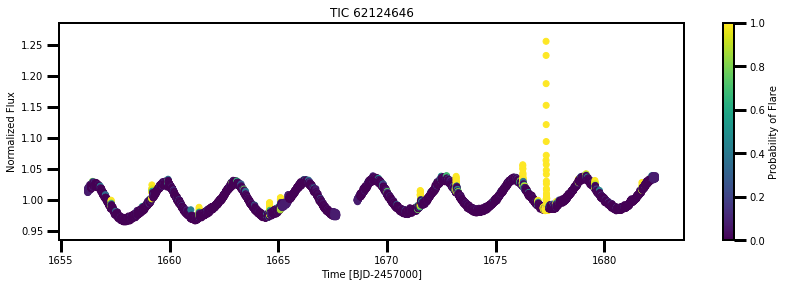

In [11]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=avg_pred, vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lk.targetid));